In [1]:
import sys
sys.path.append("..")

# basics
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import copy
import qutip

# custom stuff
import system.from_higher_basis_truncation_tunable_full_cosine as system
import utils.solver as solver
import utils.floquet_solver as fsolver
import pulse.tanh as tanh
import utils.expectation_values as expv
import utils.graph as graph
import utils.saver as saver
import utils.floquetify as floqify


# parallel utils
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor
from tqdm import tqdm as tqdm

pass

In [34]:
import dill
def load_via_dill(name):
    name = "../save_data/" + name + ".dill"
    with open(name, "rb") as f:
        return dill.load(f)
negative_first_results = load_via_dill("Dec12_4-2_tanh_params_as_function_of_amplitude")
zeroth_results = load_via_dill("Dec8_4-1_tanh_params_as_function_of_amplitude")
first_results = load_via_dill("Dec5_7-3.5_tanh_params_as_function_of_amplitude")
second_results = load_via_dill("Dec5_7-15_tanh_params_as_function_of_amplitude")
third_results = load_via_dill("Dec5_15-30_tanh_params_as_function_of_amplitude")

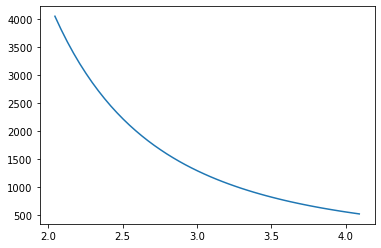

In [35]:
plt.plot([x["amplitude"] for x in negative_first_results], [x["duration"] for x in negative_first_results])

In [38]:
super_results = list((negative_first_results)) + list(np.flip(zeroth_results[0:50])) + list(np.flip(first_results)) + second_results + third_results

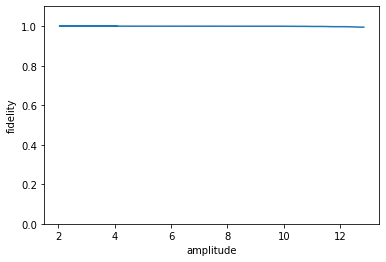

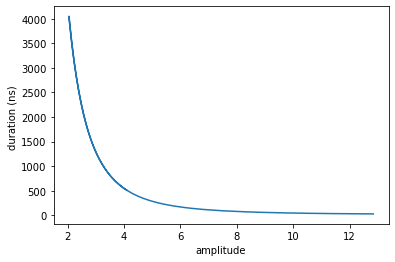

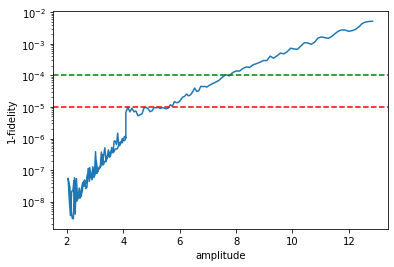

In [119]:
fids = []
durs = []
offs = []
amps = []

for j in range(len(super_results)):
    o = super_results[j]
    if (o["duration"] > 30):
        amps.append(o["amplitude"])
        durs.append(o["duration"])
        offs.append(o["offset"])
        fids.append(o["fidelity"])

plt.plot(amps, fids)
plt.ylim((0, 1.1))
plt.xlabel("amplitude")
plt.ylabel("fidelity")
plt.show()

plt.plot(amps, durs)
plt.xlabel("amplitude")
plt.ylabel("duration (ns) ")
plt.show()

plt.plot(amps, 1-np.array(fids))
plt.yscale("log")
plt.axhline(1-0.9999, linestyle='dashed', c="green")
plt.axhline(1-0.99999, linestyle='dashed', c="red")
plt.xlabel("amplitude")
plt.ylabel("1-fidelity")
plt.show()

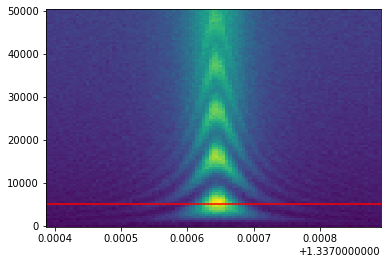

In [137]:
# create experimental graphs
# experiemental (i, amp) i from imperfect_super_results_Dec12
# 0.1 (36, 2.5883), 0.2 (116, 5.2396), 0.3 (144, 7.276), 0.05 (none), 0.07 (none), 0.15 (98, 4.050), 0.25 (134, 6.532), 0.35 (173, 10.782), 0.38 (158, 8.968)
experimental_amp = "0.07"
experimental_tlist = pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_pulseLength.csv" % experimental_amp, header=None)[0].to_list()
experimental_flist = pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_Freq.csv" % experimental_amp, header=None)[0].to_list()
experimental_fidlist = -1*np.array(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s.csv" % experimental_amp, header=None).values.tolist()).transpose()
experimental_flist_range = (np.amax(experimental_flist)*(2*np.pi) - np.amin(experimental_flist)*(2*np.pi) )
plt.pcolormesh(experimental_flist, experimental_tlist, experimental_fidlist, shading='auto')
plt.axhline(5000, c="red")
plt.show()

In [141]:
sim_exp_pairs = [(0.1, (36, 2.5883)), (0.2 ,(116, 5.2396)), (0.3, (144, 7.276)), (0.15, (98, 4.050)), (0.25, (134, 6.532)), (0.35, (173, 10.782)), (0.38, (158, 8.968))]
for pair in sim_exp_pairs:
    print(pair)
    # experiment_amp = pair[0]
    # i = pair[1][0]

(0.1, (36, 2.5883))
(0.2, (116, 5.2396))
(0.3, (144, 7.276))
(0.15, (98, 4.05))
(0.25, (134, 6.532))
(0.35, (173, 10.782))
(0.38, (158, 8.968))


In [142]:
# sim_exp_sf2s = []

In [146]:
# generate chevrons

def inner(dur):
    global _t_multiplier, _amplitude, _freq
    tlist = np.linspace(0, dur, int(dur*_t_multiplier + _t_multiplier))
    tanh.setup(amplitude=_amplitude, drive_frequency=_freq, ramp_slope=ramp_slope, cut_factor=cut_factor, tlist=tlist)
    ramp_time = 16 # roughly 13, but this makes it even closer to correct
    s = fsolver.time_evolve(system.H0, system.H1, tanh, ramp_time, ramp_time, ((2*np.pi)/_freq), tlist, system.starting_state)
    # s = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.starting_state)
    fidelity = expv.expectation_value(s.states[-1], system.target_state)
    return fidelity

def generate_fidelity_landscape(amplitude, freq_list, dur_list, t_multiplier=5, skip_rate=1):
    global _t_multiplier, _amplitude, _freq
    _t_multiplier = t_multiplier
    _amplitude = amplitude
    fids = [] # an array of columns in the landscape
    freq_points = np.linspace(np.amin(freq_list), np.amax(freq_list), int(len(freq_list)/skip_rate))
    dur_points = np.linspace(np.amin(dur_list), np.amax(dur_list), int(len(dur_list)/skip_rate))
    for f in tqdm(freq_points):
        _freq = f
        # in parallel
        fids.append(parallel_map(inner, dur_points))

        # sync
        # temp_fids = []
        # for dur in dur_points:
        #     temp_fids.append(inner(dur))
        # fids.append(temp_fids)

    fids = np.swapaxes(fids,0,1)

    plt.pcolormesh(freq_points, dur_points, fids, shading='auto')
    plt.colorbar()
    plt.xlabel("frequency (angular GHz)")
    plt.ylabel("duration (ns)")
    
    return fids 

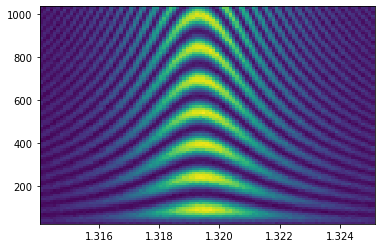

simulating system
10.0%. Run time:   0.29s. Est. time left: 00:00:00:02
20.0%. Run time:   0.56s. Est. time left: 00:00:00:02
30.0%. Run time:   0.84s. Est. time left: 00:00:00:01
40.0%. Run time:   1.11s. Est. time left: 00:00:00:01
50.0%. Run time:   1.40s. Est. time left: 00:00:00:01
60.0%. Run time:   1.70s. Est. time left: 00:00:00:01
70.0%. Run time:   1.95s. Est. time left: 00:00:00:00
80.0%. Run time:   2.18s. Est. time left: 00:00:00:00
90.0%. Run time:   2.40s. Est. time left: 00:00:00:00
Total run time:   2.60s


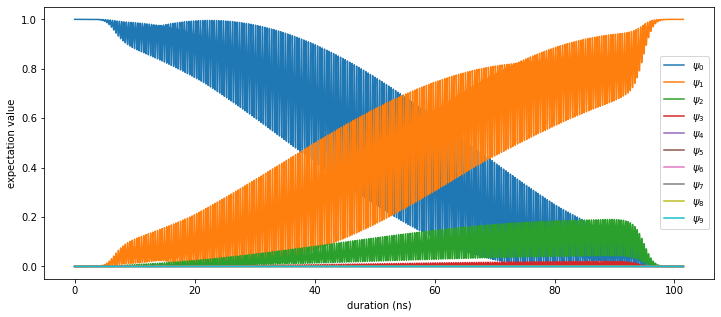

  0%|          | 0/151 [00:00<?, ?it/s]

simulation achieved fidelity:  0.9999392382330274


 23%|██▎       | 34/151 [25:00<1:21:54, 42.00s/it]

In [158]:
pair_index = 2
experimental_flist_range_multiple = 1
simulation_resolution_multiple = 1.5

# get pair info
experiment_amp = sim_exp_pairs[pair_index][0]
i = sim_exp_pairs[pair_index][1][0]

# plot experiment
experimental_tlist = pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_pulseLength.csv" % experiment_amp, header=None)[0].to_list()
experimental_flist = pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_Freq.csv" % experiment_amp, header=None)[0].to_list()
experimental_fidlist = -1*np.array(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s.csv" % experiment_amp, header=None).values.tolist()).transpose()
experimental_flist_range = (np.amax(experimental_flist)*(2*np.pi) - np.amin(experimental_flist)*(2*np.pi) )
plt.pcolormesh(experimental_flist, experimental_tlist, experimental_fidlist, shading='auto')
plt.show()
experimental_landscape = { "freq_list": experimental_flist, "dur_list": experimental_tlist, "fid_list": experimental_fidlist}


# look at system
amplitude = super_results[i]["amplitude"]
duration = super_results[i]["duration"]
off = super_results[i]["offset"]
frequency = system.first_energy_spacing/3 - off
tlist = np.arange(0, duration, (2*np.pi)/(frequency*20))
ramp_slope = 0.5
cut_factor = 3
tanh.setup(amplitude, frequency, ramp_slope, cut_factor, tlist)
print("simulating system")
s = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.starting_state, pbar=True, store_states=True)
# s = fsolver.time_evolve(system.H0, system.H1, tanh, 20, 20, (2*np.pi)/freq, tlist, system.starting_state)
graph.graph_solution(s, system) # only graphs the end of it
plt.show()
fidelity = expv.expectation_value(s.final_state, system.basis_states[1])
print("simulation achieved fidelity: ", fidelity)

# generate landscape
simulation_landscape = {}
sim_fid_halfrange = (experimental_flist_range * experimental_flist_range_multiple)/2
simulation_landscape["freq_list"] = np.linspace(frequency-sim_fid_halfrange, frequency+sim_fid_halfrange, int(len(experimental_tlist)*simulation_resolution_multiple))
simulation_landscape["dur_list"] = np.linspace(np.amin(experimental_tlist), np.amax(experimental_tlist), int(len(experimental_tlist)*simulation_resolution_multiple))
simulation_landscape["fid_list"] = generate_fidelity_landscape(amplitude, simulation_landscape["freq_list"], simulation_landscape["dur_list"])

sim_exp_sf2s.append( { "experimental_landscape": experimental_landscape, "simulation_landscape": simulation_landscape, "simulation_origin_result": super_results[i], "experiment_amp": experiment_amp })

In [ ]:
pair_index = 3
experimental_flist_range_multiple = 1
simulation_resolution_multiple = 1.5

# get pair info
experiment_amp = sim_exp_pairs[pair_index][0]
i = sim_exp_pairs[pair_index][1][0]

# plot experiment
experimental_tlist = pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_pulseLength.csv" % experiment_amp, header=None)[0].to_list()
experimental_flist = pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_Freq.csv" % experiment_amp, header=None)[0].to_list()
experimental_fidlist = -1*np.array(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s.csv" % experiment_amp, header=None).values.tolist()).transpose()
experimental_flist_range = (np.amax(experimental_flist)*(2*np.pi) - np.amin(experimental_flist)*(2*np.pi) )
plt.pcolormesh(experimental_flist, experimental_tlist, experimental_fidlist, shading='auto')
plt.show()
experimental_landscape = { "freq_list": experimental_flist, "dur_list": experimental_tlist, "fid_list": experimental_fidlist}


# look at system
amplitude = super_results[i]["amplitude"]
duration = super_results[i]["duration"]
off = super_results[i]["offset"]
frequency = system.first_energy_spacing/3 - off
tlist = np.arange(0, duration, (2*np.pi)/(frequency*20))
ramp_slope = 0.5
cut_factor = 3
tanh.setup(amplitude, frequency, ramp_slope, cut_factor, tlist)
print("simulating system")
s = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.starting_state, pbar=True, store_states=True)
# s = fsolver.time_evolve(system.H0, system.H1, tanh, 20, 20, (2*np.pi)/freq, tlist, system.starting_state)
graph.graph_solution(s, system) # only graphs the end of it
plt.show()
fidelity = expv.expectation_value(s.final_state, system.basis_states[1])
print("simulation achieved fidelity: ", fidelity)

# generate landscape
simulation_landscape = {}
sim_fid_halfrange = (experimental_flist_range * experimental_flist_range_multiple)/2
simulation_landscape["freq_list"] = np.linspace(frequency-sim_fid_halfrange, frequency+sim_fid_halfrange, int(len(experimental_tlist)*simulation_resolution_multiple))
simulation_landscape["dur_list"] = np.linspace(np.amin(experimental_tlist), np.amax(experimental_tlist), int(len(experimental_tlist)*simulation_resolution_multiple))
simulation_landscape["fid_list"] = generate_fidelity_landscape(amplitude, simulation_landscape["freq_list"], simulation_landscape["dur_list"])

sim_exp_sf2s.append( { "experimental_landscape": experimental_landscape, "simulation_landscape": simulation_landscape, "simulation_origin_result": super_results[i], "experiment_amp": experiment_amp })

In [ ]:
pair_index = 4
experimental_flist_range_multiple = 1
simulation_resolution_multiple = 1.5

# get pair info
experiment_amp = sim_exp_pairs[pair_index][0]
i = sim_exp_pairs[pair_index][1][0]

# plot experiment
experimental_tlist = pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_pulseLength.csv" % experiment_amp, header=None)[0].to_list()
experimental_flist = pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_Freq.csv" % experiment_amp, header=None)[0].to_list()
experimental_fidlist = -1*np.array(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s.csv" % experiment_amp, header=None).values.tolist()).transpose()
experimental_flist_range = (np.amax(experimental_flist)*(2*np.pi) - np.amin(experimental_flist)*(2*np.pi) )
plt.pcolormesh(experimental_flist, experimental_tlist, experimental_fidlist, shading='auto')
plt.show()
experimental_landscape = { "freq_list": experimental_flist, "dur_list": experimental_tlist, "fid_list": experimental_fidlist}


# look at system
amplitude = super_results[i]["amplitude"]
duration = super_results[i]["duration"]
off = super_results[i]["offset"]
frequency = system.first_energy_spacing/3 - off
tlist = np.arange(0, duration, (2*np.pi)/(frequency*20))
ramp_slope = 0.5
cut_factor = 3
tanh.setup(amplitude, frequency, ramp_slope, cut_factor, tlist)
print("simulating system")
s = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.starting_state, pbar=True, store_states=True)
# s = fsolver.time_evolve(system.H0, system.H1, tanh, 20, 20, (2*np.pi)/freq, tlist, system.starting_state)
graph.graph_solution(s, system) # only graphs the end of it
plt.show()
fidelity = expv.expectation_value(s.final_state, system.basis_states[1])
print("simulation achieved fidelity: ", fidelity)

# generate landscape
simulation_landscape = {}
sim_fid_halfrange = (experimental_flist_range * experimental_flist_range_multiple)/2
simulation_landscape["freq_list"] = np.linspace(frequency-sim_fid_halfrange, frequency+sim_fid_halfrange, int(len(experimental_tlist)*simulation_resolution_multiple))
simulation_landscape["dur_list"] = np.linspace(np.amin(experimental_tlist), np.amax(experimental_tlist), int(len(experimental_tlist)*simulation_resolution_multiple))
simulation_landscape["fid_list"] = generate_fidelity_landscape(amplitude, simulation_landscape["freq_list"], simulation_landscape["dur_list"])

sim_exp_sf2s.append( { "experimental_landscape": experimental_landscape, "simulation_landscape": simulation_landscape, "simulation_origin_result": super_results[i], "experiment_amp": experiment_amp })

In [ ]:
pair_index = 5
experimental_flist_range_multiple = 1
simulation_resolution_multiple = 1.5

# get pair info
experiment_amp = sim_exp_pairs[pair_index][0]
i = sim_exp_pairs[pair_index][1][0]

# plot experiment
experimental_tlist = pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_pulseLength.csv" % experiment_amp, header=None)[0].to_list()
experimental_flist = pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_Freq.csv" % experiment_amp, header=None)[0].to_list()
experimental_fidlist = -1*np.array(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s.csv" % experiment_amp, header=None).values.tolist()).transpose()
experimental_flist_range = (np.amax(experimental_flist)*(2*np.pi) - np.amin(experimental_flist)*(2*np.pi) )
plt.pcolormesh(experimental_flist, experimental_tlist, experimental_fidlist, shading='auto')
plt.show()
experimental_landscape = { "freq_list": experimental_flist, "dur_list": experimental_tlist, "fid_list": experimental_fidlist}


# look at system
amplitude = super_results[i]["amplitude"]
duration = super_results[i]["duration"]
off = super_results[i]["offset"]
frequency = system.first_energy_spacing/3 - off
tlist = np.arange(0, duration, (2*np.pi)/(frequency*20))
ramp_slope = 0.5
cut_factor = 3
tanh.setup(amplitude, frequency, ramp_slope, cut_factor, tlist)
print("simulating system")
s = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.starting_state, pbar=True, store_states=True)
# s = fsolver.time_evolve(system.H0, system.H1, tanh, 20, 20, (2*np.pi)/freq, tlist, system.starting_state)
graph.graph_solution(s, system) # only graphs the end of it
plt.show()
fidelity = expv.expectation_value(s.final_state, system.basis_states[1])
print("simulation achieved fidelity: ", fidelity)

# generate landscape
simulation_landscape = {}
sim_fid_halfrange = (experimental_flist_range * experimental_flist_range_multiple)/2
simulation_landscape["freq_list"] = np.linspace(frequency-sim_fid_halfrange, frequency+sim_fid_halfrange, int(len(experimental_tlist)*simulation_resolution_multiple))
simulation_landscape["dur_list"] = np.linspace(np.amin(experimental_tlist), np.amax(experimental_tlist), int(len(experimental_tlist)*simulation_resolution_multiple))
simulation_landscape["fid_list"] = generate_fidelity_landscape(amplitude, simulation_landscape["freq_list"], simulation_landscape["dur_list"])

sim_exp_sf2s.append( { "experimental_landscape": experimental_landscape, "simulation_landscape": simulation_landscape, "simulation_origin_result": super_results[i], "experiment_amp": experiment_amp })

In [ ]:
pair_index = 6
experimental_flist_range_multiple = 1
simulation_resolution_multiple = 1.5

# get pair info
experiment_amp = sim_exp_pairs[pair_index][0]
i = sim_exp_pairs[pair_index][1][0]

# plot experiment
experimental_tlist = pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_pulseLength.csv" % experiment_amp, header=None)[0].to_list()
experimental_flist = pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s_Freq.csv" % experiment_amp, header=None)[0].to_list()
experimental_fidlist = -1*np.array(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp%s.csv" % experiment_amp, header=None).values.tolist()).transpose()
experimental_flist_range = (np.amax(experimental_flist)*(2*np.pi) - np.amin(experimental_flist)*(2*np.pi) )
plt.pcolormesh(experimental_flist, experimental_tlist, experimental_fidlist, shading='auto')
plt.show()
experimental_landscape = { "freq_list": experimental_flist, "dur_list": experimental_tlist, "fid_list": experimental_fidlist}


# look at system
amplitude = super_results[i]["amplitude"]
duration = super_results[i]["duration"]
off = super_results[i]["offset"]
frequency = system.first_energy_spacing/3 - off
tlist = np.arange(0, duration, (2*np.pi)/(frequency*20))
ramp_slope = 0.5
cut_factor = 3
tanh.setup(amplitude, frequency, ramp_slope, cut_factor, tlist)
print("simulating system")
s = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.starting_state, pbar=True, store_states=True)
# s = fsolver.time_evolve(system.H0, system.H1, tanh, 20, 20, (2*np.pi)/freq, tlist, system.starting_state)
graph.graph_solution(s, system) # only graphs the end of it
plt.show()
fidelity = expv.expectation_value(s.final_state, system.basis_states[1])
print("simulation achieved fidelity: ", fidelity)

# generate landscape
simulation_landscape = {}
sim_fid_halfrange = (experimental_flist_range * experimental_flist_range_multiple)/2
simulation_landscape["freq_list"] = np.linspace(frequency-sim_fid_halfrange, frequency+sim_fid_halfrange, int(len(experimental_tlist)*simulation_resolution_multiple))
simulation_landscape["dur_list"] = np.linspace(np.amin(experimental_tlist), np.amax(experimental_tlist), int(len(experimental_tlist)*simulation_resolution_multiple))
simulation_landscape["fid_list"] = generate_fidelity_landscape(amplitude, simulation_landscape["freq_list"], simulation_landscape["dur_list"])

sim_exp_sf2s.append( { "experimental_landscape": experimental_landscape, "simulation_landscape": simulation_landscape, "simulation_origin_result": super_results[i], "experiment_amp": experiment_amp })

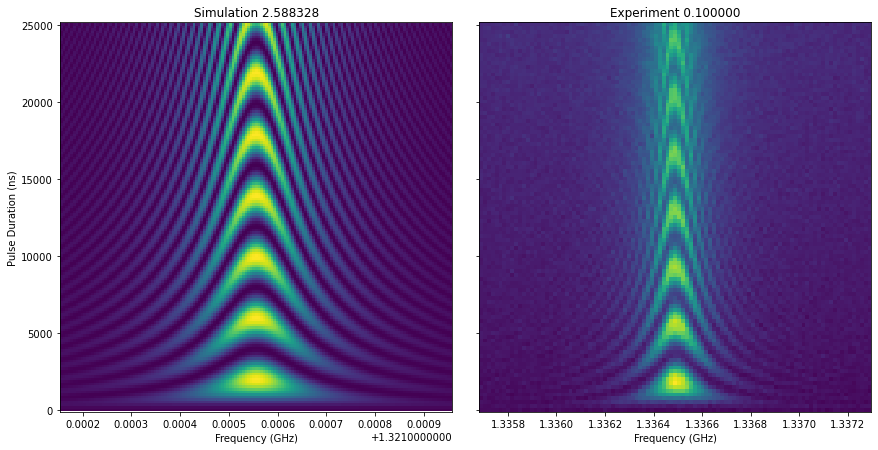

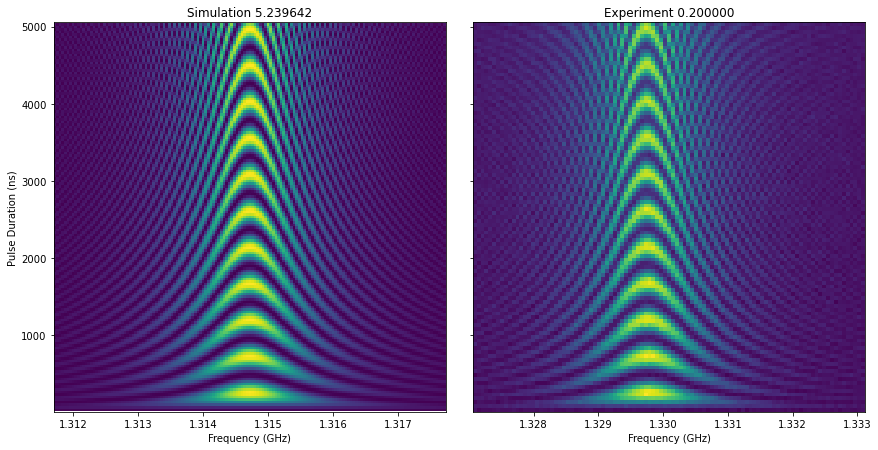

In [157]:
#define grid of plots
for obj in sim_exp_sf2s:
    experimental_landscape = obj["experimental_landscape"]
    simulation_landscape = obj["simulation_landscape"]

    fig, axs = plt.subplots(figsize=(12,6), nrows=1, ncols=2, sharey=True)
    fig.tight_layout()
    #add data to plots
    axs[0].set_title("Simulation %f" % obj["simulation_origin_result"]["amplitude"])
    axs[0].set_xlabel("Frequency (GHz)")
    axs[0].set_ylabel("Pulse Duration (ns)")
    axs[0].pcolormesh(simulation_landscape["freq_list"] / (2*np.pi), simulation_landscape["dur_list"], simulation_landscape["fid_list"], shading="auto")
    axs[1].set_title("Experiment %f" % obj["experiment_amp"])
    axs[1].set_xlabel("Frequency (GHz)")
    axs[1].pcolormesh(experimental_landscape["freq_list"], experimental_landscape["dur_list"], experimental_landscape["fid_list"], shading='auto')
    plt.show()